In [1]:
# IMPORTANTE
# TODO: tentar uma unica variaval para ruptura

# ranqueamento das lojas
# se tiver presenca e eu marquei pontos la em cima, poderia contar como erro.

# Historico
- Rede dupla e/ou com 100 neuronios: ruim. Nos primeiros passos o resultado fica razoavel, mas quando avanca piora.
- Rede unica com 10 neuronios: bom.

In [1]:
#https://machinelearningmastery.com/timedistributed-layer-for-long-short-term-memory-networks-in-python/
import sys 
import json
import numpy as np # linear algebra
import matplotlib.pyplot as plt # this is used for the plot the graph 
import math
import collections
import pandas as pd

## for Deep-learing:
import keras
import tensorflow as tf
from keras import backend as K
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import TimeDistributed
from keras.layers import Lambda
from keras.models import model_from_json
from tensorflow.python.keras.callbacks import TensorBoard

from itertools import product
from functools import partial
from time import time

from core.DataExploration import DataExploration
from core.ModelIndicators import ModelIndicators
from ruptura.CreateBatch import CreateBatch
from ruptura.RupturaPrediction import RupturaPrediction
from ruptura.RupturaNeuralNetwork import RupturaNeuralNetwork

Using TensorFlow backend.


In [2]:
version = '0-0-3'
referenceDate = '1/03/2019'
modelName = 'model-' + version

# CARREGAMENTO DOS DADOS

In [4]:
createBatch = CreateBatch(version)
X, Y, Ytest = createBatch.batch('barbieri-encode-3-1-3-19.json')

WARNING - need error handling on samples


# MODEL DEFINITION

In [8]:
batch_size = 64
time_steps = X.shape[1]
x_dimension = X.shape[2]
y_dimension = Y.shape[2]
rupNN = RupturaNeuralNetwork(modelName)
newModel = True

if newModel:
    n_neurons = 12
    model = Sequential()
    model.add(LSTM(n_neurons, input_shape=(time_steps, x_dimension), return_sequences=True)) 
    model.add(TimeDistributed(Dense(y_dimension, activation='softmax')))
    #model.add(LSTM(n_neurons, input_shape=(time_steps, x_dimension), return_sequences=True)) 
    #model.add(TimeDistributed(Dense(x_dimension, activation='softmax')))
    model.compile(
        loss=rupNN.getCustomLoss((batch_size,time_steps)),
        #loss = 'categorical_crossentropy', 
        optimizer='adam')
    print('MODEL CREATED\n')
    print(model.summary())
else:
    model = rupNN.loadModel((batch_size,time_steps))  # Y dimensions are needed for custom loss definitions
    print('MODEL LOADED\n')
    print(model.summary())

MODEL CREATED

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 60, 12)            816       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 60, 3)             39        
Total params: 855
Trainable params: 855
Non-trainable params: 0
_________________________________________________________________
None


# TRAINING

In [ ]:
cut1 = batch_size
cut2 = X.shape[0] - X.shape[0]%batch_size
Xval, Xtrain,_ = np.split(X,[cut1,cut2])
Yval, Ytrain,_ = np.split(Y,[cut1,cut2])
for step in range(30):
    n_epoch = 100
    model.fit(Xtrain, Ytrain, 
                  epochs=n_epoch, 
                  batch_size= batch_size, 
                  validation_data=(Xval, Yval),
                  verbose=2)
    rupNN.saveModel(model)

Train on 2304 samples, validate on 64 samples
Epoch 1/100
 - 8s - loss: 0.3521 - val_loss: 0.3928
Epoch 2/100
 - 6s - loss: 0.3376 - val_loss: 0.3844
Epoch 3/100
 - 6s - loss: 0.3287 - val_loss: 0.3657
Epoch 4/100
 - 6s - loss: 0.3128 - val_loss: 0.3395
Epoch 5/100
 - 6s - loss: 0.3011 - val_loss: 0.3267
Epoch 6/100
 - 6s - loss: 0.2941 - val_loss: 0.3185
Epoch 7/100
 - 6s - loss: 0.2887 - val_loss: 0.3143
Epoch 8/100
 - 6s - loss: 0.2852 - val_loss: 0.3135
Epoch 9/100
 - 6s - loss: 0.2829 - val_loss: 0.3130
Epoch 10/100
 - 6s - loss: 0.2808 - val_loss: 0.3077
Epoch 11/100
 - 6s - loss: 0.2784 - val_loss: 0.3059
Epoch 12/100
 - 6s - loss: 0.2760 - val_loss: 0.3027
Epoch 13/100
 - 6s - loss: 0.2737 - val_loss: 0.3003
Epoch 14/100
 - 6s - loss: 0.2713 - val_loss: 0.2993
Epoch 15/100
 - 6s - loss: 0.2689 - val_loss: 0.2952
Epoch 16/100
 - 6s - loss: 0.2668 - val_loss: 0.2943
Epoch 17/100
 - 6s - loss: 0.2649 - val_loss: 0.2929
Epoch 18/100


# VALIDATION

Contratos adimplentes:   912
Contratos inadimlentes:  569
xAxis:   [0.0, 24.75, 49.5, 74.25, 99.0] 

yAxis:   [12, 29, 59, 80, 83] 



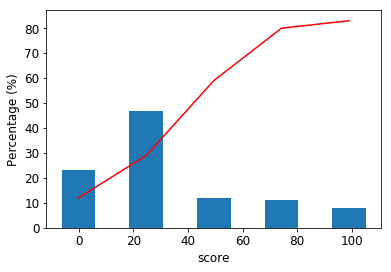

In [11]:
rupPred = RupturaPrediction(X)
rupPred.addFirstPrediction(Y)
rupPred.validate(Ytest, model)
dataScore = rupPred.calculateDataScore()  # passo que define a validacao
rupPred.plotScore(dataScore)

In [12]:
pred = dataScore.score.tolist()
ytrue = dataScore.Inadimplente.tolist()
ytrue = [int(x) for x in ytrue]
modelIndicators = ModelIndicators(version)
modelIndicators.TARGET_SCORE_CUT = 50
modelIndicators.setPredProbs(ytrue,pred)
indic = modelIndicators.allIndicators()
file = open('ruptura-indicators.csv','a+')
file.write('\n' + 'version;' + version + ';' + 'referenceDate;' + referenceDate + '\n')
for i in range(len(indic)):
    file.write(str(indic.index[i]) + ';' + str(indic.iloc[i,0]) + '\n')
file.close()